In [34]:
import numpy as np
from numba import jit
from scipy.sparse import csr_matrix

k = 5


def generate_A(N):
    h = 1 / N
    size = (N - 1) ** 2
    const = h ** 2 * k ** 2
    A = np.zeros((size, size))
    for i in range(size):
        for j in range(i, size):
            if i == j:
                A[i, j] = A[j, i] = (24 - 4 * const) / 9
            elif (i == j - 1 and j % (N - 1) != 0) or j - i == N - 1:
                A[i, j] = A[j, i] = (-3 - const) / 9
            elif (j - i == N and j % (N - 1) != 0) or (j - i == N - 2 and i % (N - 1) != 0):
                A[i, j] = A[j, i] = (-12 - const) / 36
    return csr_matrix(A)


@jit(nopython=True)
def generate_b(N):
    def func_g(x, y):
        return np.sin(3 * x + 4 * y)

    h = 1 / N
    # nnz = 4 * (N - 2)
    size = (N - 1) ** 2
    data = np.zeros(size)

    const = h ** 2 * k ** 2
    const1 = (12 + const) / 36
    const2 = (3 + const) / 9

    for condition in range(4):
        for i in range(N - 2):
            position = i + 1
            if condition == 0:
                if position == 1:
                    g1 = func_g(0, 0) + func_g(2 * h, 0) + func_g(0, 2 * h)
                    g2 = func_g(h, 0) + func_g(0, h)
                else:
                    g1 = func_g(position * h + h, 0) + func_g(position * h - h, 0)
                    g2 = func_g(position * h, 0)
                row_index = position - 1
            elif condition == 1:
                if position == 1:
                    g1 = func_g(1, 0) + func_g(1, 2 * h) + func_g(1 - 2 * h, 0)
                    g2 = func_g(1 - h, 0) + func_g(1, h)
                else:
                    g1 = func_g(1, position * h + h) + func_g(1, position * h - h)
                    g2 = func_g(1, position * h)
                row_index = position * (N - 1) - 1
            elif condition == 2:
                if position == 1:
                    g1 = func_g(1, 1) + func_g(1 - 2 * h, 1) + func_g(1, 1 - 2 * h)
                    g2 = func_g(1 - h, 1) + func_g(1, 1 - h)
                else:
                    g1 = func_g(position * h + h, 1) + func_g(position * h - h, 1)
                    g2 = func_g(position * h, 1)
                row_index = (N - 1) ** 2 - position
            else:
                position += 1
                if position == N - 1:
                    g1 = func_g(0, 1) + func_g(2 * h, 1) + func_g(0, 1 - 2 * h)
                    g2 = func_g(h, 1) + func_g(0, 1 - h)
                else:
                    g1 = func_g(0, position * h + h) + func_g(0, position * h - h)
                    g2 = func_g(0, position * h)
                row_index = (N - 1) * (position - 1)

            data[row_index] = g1 * const1 + g2 * const2

    return data



* solve the matrix-vector problem for $N=4$, $N=8$, and $N=16$

* plot the approximate solutions to the Helmholtz problem.

In [35]:
def solve_x(N):
    A = generate_A(N)
    b = generate_b(N)
    u = spsolve(A, b).reshape((N - 1, N - 1))
    return u

In [36]:
% matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.sparse.linalg import spsolve
from tqdm.notebook import tqdm

Ns = [4, 8, 16, 55, 100]


def plot():
    fig = plt.figure(figsize=(5 * len(Ns), 22))

    for i, N in enumerate(tqdm(Ns)):
        u = solve_x(N)

        ticksX = ticksY = np.linspace(0, 1, N - 1)
        X, Y = np.meshgrid(ticksX, ticksY)

        ax = fig.add_subplot(1, len(Ns), i + 1, projection='3d')
        ax.plot_surface(X, Y, u, antialiased=False, cmap=cm.coolwarm)
        ax.set_xlabel(r'$t$')
        ax.set_ylabel(r'$x$')
        ax.set_zlabel(r'N = {}'.format(N))
    fig.tight_layout(h_pad=4)
    plt.show()


plot()

UsageError: Line magic function `%` not found.


* solve the matrix-vector problem with small to medium-sized value of $N$ using a range of different solvers of your choice

    * at least **5** matrix-vector solvers:
        * at least **2** of these should be **iterative** solvers, at least **1** should be a **direct** solver.
        * use some solvers from the Scipy library and some from **PETSc**.

* measuring factors you deem to be important for your evaluation.

    * factors should include the **time** taken by the solver,

        * may additionally include many other things, such as:

          1. the number of **iterations**
          2. the size of the **residual** after each iteration


* Make a set of plots that show the measurements you have made and allow you to compare the solvers.



spsolve
PETSc!
numpy的解法？或者PETSc多选几个
iterative: cg gmres

In [37]:
!pip install petsc4py

^C


In [38]:
% matplotlib inline
import matplotlib.pyplot as plt
import timeit
from petsc4py import PETSc
from scipy.sparse.linalg import spsolve
from tqdm.notebook import tqdm

Ns = np.linspace(2, 20, 10, dtype=np.int32)


class Solver:
    def __init__(self, name: str):
        self.name = name
        self.times = []
        self.solution = []
        self.error = []
        self.PC = 'none'
        self.residuals = None


def test_solvers():
    PET_solvers = [Solver(name) for name in ['dgmres', 'cg', 'cr', 'nash', 'richardson']]
    sp = Solver('spsolver')
    for N in tqdm(Ns):
        A = generate_A(N)
        b = generate_b(N)

        sp.solution += [spsolve(A, b)]
        sp.times += [timeit.Timer(lambda: spsolve(A, b)).timeit(1)]

        AA = PETSc.Mat()
        AA.createAIJWithArrays(A.shape, (A.indptr, A.indices, A.data))
        bb = AA.createVecLeft()
        bb.array[:] = b

        for pet_solver in PET_solvers:
            ksp = PETSc.KSP().create()
            ksp.setOperators(AA)
            pet_solver.solution.append(AA.createVecRight())

            ksp.setType(pet_solver.name)
            ksp.getPC().setType(pet_solver.PC)
            ksp.setConvergenceHistory()

            pet_solver.times += [timeit.Timer(lambda: ksp.solve(bb, pet_solver.solution[-1])).timeit(1)]
            pet_solver.residuals += [ksp.getConvergenceHistory()]

    PET_solvers.append(sp)

    fig = plt.figure(figsize=(10, 20))

    plt.subplot(2, 1, 1)
    ps = []
    for i, sv in enumerate(PET_solvers):
        print('{} : {}'.format(sv.name, sv.times))
        p0, = plt.plot(Ns, sv.times)
        ps += [p0]

    plt.legend(ps, [sv.name for sv in PET_solvers], loc='upper left')
    plt.ylabel('time')
    plt.xlabel('N')

    plt.subplot(2, 1, 2)
    ps = []
    for i, sv in enumerate(PET_solvers):
        if i == len(PET_solvers) - 1: continue
        p0, = plt.semilogy(sv.residuals)
        ps += [p0]
    plt.legend(ps, [sv.name for sv in PET_solvers], loc='upper left')

    plt.ylabel('residuals')
    plt.xlabel('iterations')

    plt.show()


test_solvers()


UsageError: Line magic function `%` not found.


* For two of the iterative solvers you have chosen to use, repeat the comparisons with three different choices of preconditioner.

In [ ]:
% matplotlib inline
import matplotlib.pyplot as plt
import timeit
from petsc4py import PETSc
from scipy.sparse.linalg import spsolve
from tqdm.notebook import tqdm

Ns = np.linspace(2, 20, 10, dtype=np.int32)


class Solver:
    def __init__(self, name: str):
        self.name = name
        self.times = []
        self.error = []
        self.PC = 'none'


def calculate_error(sol, N):
    x = y = np.linspace(0, 1, N)
    u_exact = np.sin(3 * x + 4 * y)


def test_solvers():
    PET_solvers = [Solver(name) for name in ['cg', 'nash']]

    for N in tqdm(Ns):
        A = generate_A(N)
        b = generate_b(N)

        AA = PETSc.Mat()
        AA.createAIJWithArrays(A.shape, (A.indptr, A.indices, A.data))
        bb = AA.createVecLeft()
        bb.array[:] = b

        for pet_solver in PET_solvers:
            ksp = PETSc.KSP().create()
            ksp.setOperators(AA)
            pet_solver.solution = AA.createVecRight()

            ksp.setType(pet_solver.name)
            ksp.getPC().setType(pet_solver.PC)

            pet_solver.times += [timeit.Timer(lambda: ksp.solve(bb, pet_solver.solution)).timeit(1)]

    fig = plt.figure(figsize=(10, 20))

    ps = []
    for i, sv in enumerate(PET_solvers):
        print('{} : {}'.format(sv.name, sv.times))
        p0, = plt.plot(Ns, sv.times)
        ps += [p0]

    plt.legend(ps, [sv.name for sv in PET_solvers], loc='upper left')
    plt.ylabel('time')
    plt.xlabel('N')


test_solvers()


  0%|          | 0/3 [00:00<?, ?it/s]

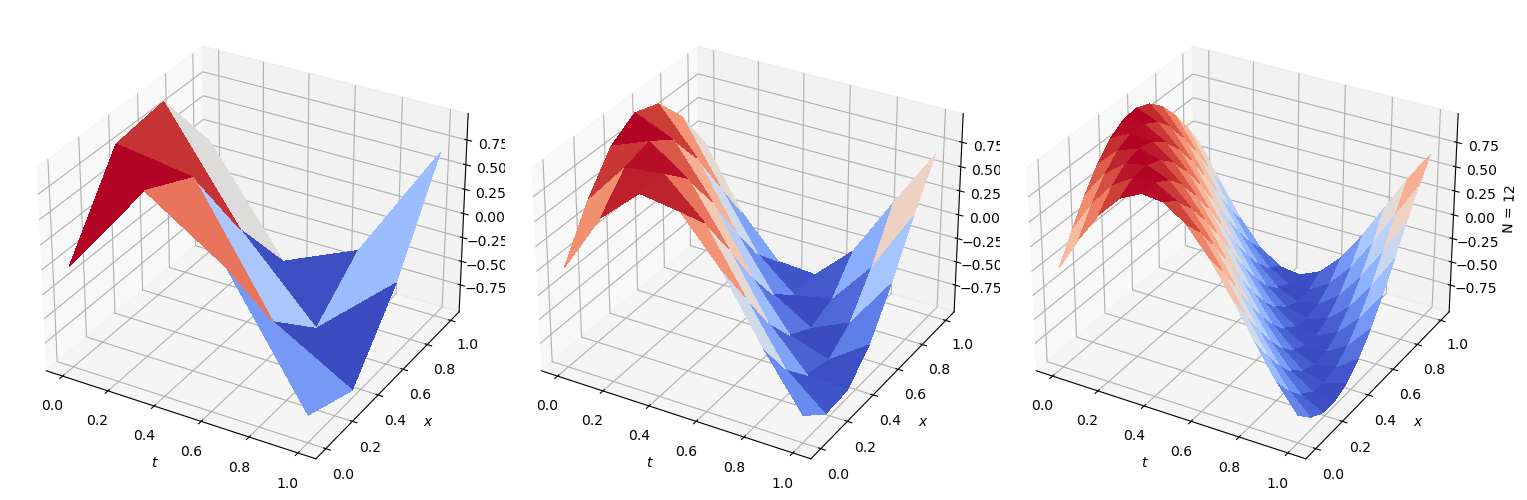

In [30]:
import numpy as np


def get_true_u(N):
    u_exact = np.zeros((N, N))
    for i, x in enumerate(np.linspace(0, 1, N)):
        for j, y in enumerate(np.linspace(0, 1, N)):
            u_exact[i, j] = np.sin(3 * x + 4 * y)
    return u_exact


def calculate_error(u, N):
    error_mat = u - get_true_u(N - 1)

